In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from dynaconf import Dynaconf
import joblib

from src.models.mf_with_bias import MatrixFactorizationWithBias
from src.lit_models.base import LightningModel

# Setup model and config

Load config file with `Dynaconf`

In [2]:
cfg = Dynaconf(root_path="configs", settings_files=["config_mf.yaml"])

Load model inputs from the config file

In [3]:
n_users = cfg.model.pytorch_model.init_args.n_users
n_items = cfg.model.pytorch_model.init_args.n_items
n_factors = cfg.model.pytorch_model.init_args.n_factors
print(f"{n_users=}, {n_items=}, {n_factors=}")

n_users=943, n_items=1625, n_factors=128


Load pytroch model with bias embeddings

In [4]:
pytorch_model = MatrixFactorizationWithBias(n_users, n_items, n_factors)

Load checkpoint

In [5]:
checkpoint_file = "lightning_logs/embedding_dim/version_1/checkpoints/best_model.ckpt"

# load weights
model = LightningModel.load_from_checkpoint(
    checkpoint_path=checkpoint_file, pytorch_model=pytorch_model
)

In [6]:
# device = model.device
# print(device)

# Interpreting Embeddings and Biases

The first we want to do is load the data and the mappings of items to idx.

This sections comes from this notebook [Collaborative Filtering Deep Dive](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive?scriptVersionId=99475018&cellId=90) from [Jeremy Howard](https://www.kaggle.com/jhoward)




## Load data

Import data and mappings

In [7]:
# Read titles
train = pd.read_pickle("output/datasets/ml-100k/ml-100k_train.pkl")
print(f"{train.shape=}")
print(f"{train.user_id.nunique()=}")
print(f"{train.item_id.nunique()=}")
train.head()

train.shape=(64002, 8)
train.user_id.nunique()=625
train.item_id.nunique()=1549


,user_id,item_id,rating,timestamp,title,user_enc,title_enc,rating_scaled
0,259,255,4,1997-09-20 05:05:10,My Best Friend's Wedding (1997),1,1,0.75
1,259,286,4,1997-09-20 05:05:27,"English Patient, The (1996)",1,2,0.75
2,259,298,4,1997-09-20 05:05:54,Face/Off (1997),1,3,0.75
3,259,185,4,1997-09-20 05:06:21,Psycho (1960),1,4,0.75
4,259,173,4,1997-09-20 05:07:23,"Princess Bride, The (1987)",1,5,0.75


### Load mappings 

Load mapping item2int and reverse mapping

In [8]:
item2int = joblib.load("output/encoders/ml-100k/title_encoder.joblib")
int2item = {v: k for k, v in item2int.items()}

Load mapping user2int and reverse mapping

In [9]:
user2int = joblib.load("output/encoders/ml-100k/user_encoder.joblib")
int2user = {v: k for k, v in user2int.items()}

## Item bias embeddings

Here are the movies with the lowest values in the bias vector:

In [10]:
item_bias = model.pytorch_model.item_bias.weight.cpu().detach().numpy().squeeze()
print(f"Item (movie) bias shape: {item_bias.shape}")

idx = item_bias.argsort()[:5]
print(idx)
[(i, int2item[i]) for i in idx]

Item (movie) bias shape: (1625,)
[ 960  902  774 1436 1492]


[(960, 'Girl in the Cadillac (1995)'),
 (902, 'Simple Wish, A (1997)'),
 (774, 'Amityville 3-D (1983)'),
 (1436, 'Castle Freak (1995)'),
 (1492, 'Tough and Deadly (1995)')]

Think about what this means. What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! By the same token, here are the movies with the highest bias:

In [11]:
# argsort() -> reverse order -> subset first 5
idx = item_bias.argsort()[::-1][:5]
[f"idx: {i}, {int2item[i]}" for i in idx]

['idx: 988, L.A. Confidential (1997)',
 'idx: 1451, Titanic (1997)',
 'idx: 1042, Full Monty, The (1997)',
 'idx: 120, Air Force One (1997)',
 'idx: 2, English Patient, The (1996)']

## Item embeddings

Analysis of the item embeddings

### PCA

Here's what our movies look like based on two of the strongest PCA components.

In [12]:
from sklearn.decomposition import PCA

In [13]:
item_emb = model.pytorch_model.item_emb.weight.cpu().detach().numpy()
print(f"item_emb shpe {item_emb.shape}")

item_emb shpe (1625, 128)


Select most rated movies

In [14]:
g = train.groupby("title").size()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = [item2int[m] for m in top_movies]
movie_w = item_emb[top_idxs, :].copy()

In [15]:
movie_pca = PCA(n_components=2)
X_trans = movie_pca.fit_transform(movie_w)
print(f"Explained variance: {movie_pca.explained_variance_}")

Explained variance: [0.12191831 0.03814667]


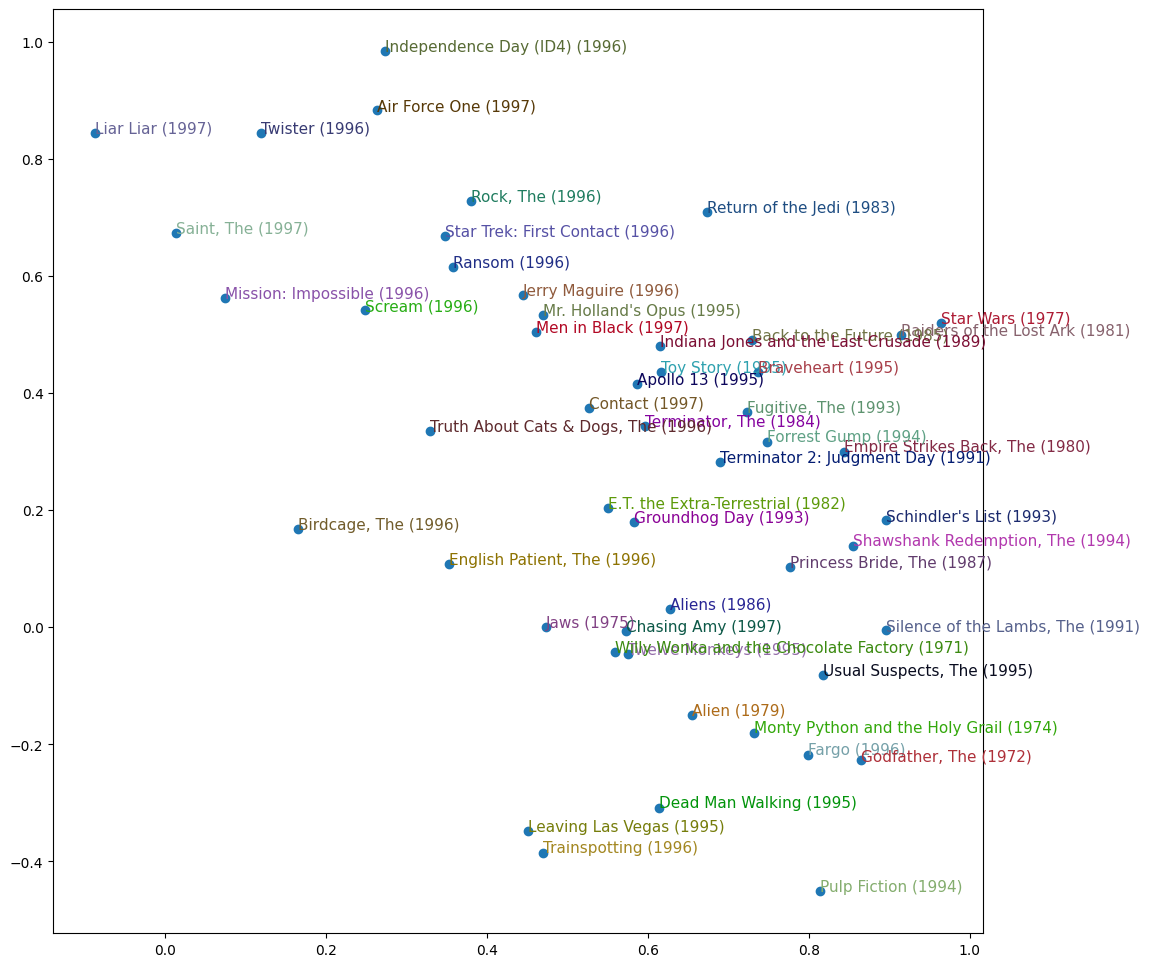

In [16]:
import numpy as np
import matplotlib.pyplot as plt

idxs = list(range(50))
X = X_trans[idxs, 0]
Y = X_trans[idxs, 1]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for x, y, t in zip(X, Y, top_movies[idxs]):
    plt.text(x, y, t, color=np.random.rand(3)*0.7, fontsize=11)

### TSNE

In [17]:
from sklearn.manifold import TSNE

In [18]:
movie_tsne = TSNE(n_components=2, perplexity=30)
X_trans = movie_tsne.fit_transform(movie_w)

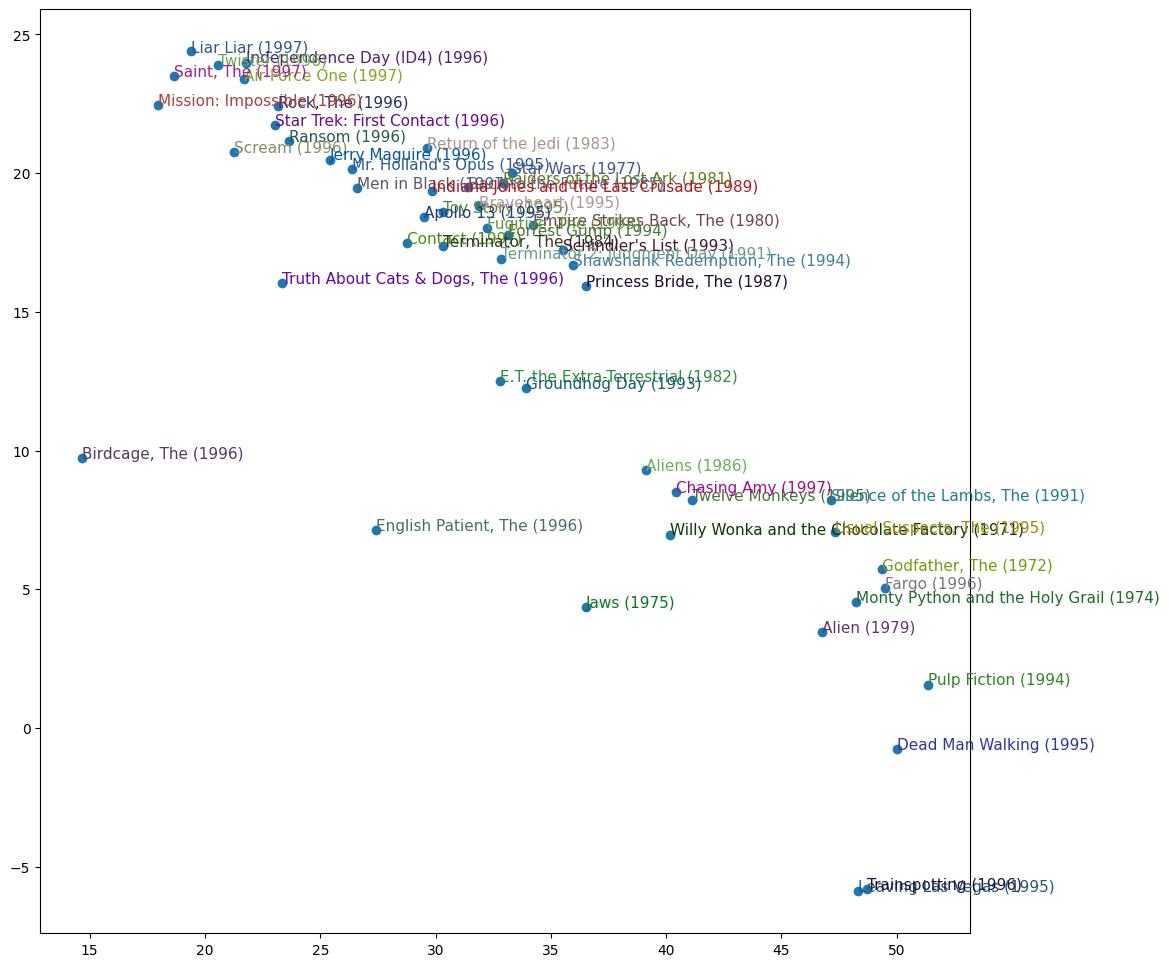

In [19]:
idxs = list(range(50))
X = X_trans[idxs, 0]
Y = X_trans[idxs, 1]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for x, y, t in zip(X, Y, top_movies[idxs]):
    plt.text(x, y, t, color=np.random.rand(3)*0.7, fontsize=11)

### Embedding Distance

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras, (assuming that x and y are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to Silence of the Lambs:

In [20]:
import torch.nn as nn

In [21]:
item_emb = model.pytorch_model.item_emb.weight

title = 'Silence of the Lambs, The (1991)'
idx = item2int[title]

distances = nn.CosineSimilarity(dim=1)(item_emb, item_emb[idx][None])
distances

idxs = distances.argsort(descending=True)[:5]
# int2item[int(idxs.detach().numpy())]

[int2item[int(idx.detach().numpy())] for idx in idxs]

['Silence of the Lambs, The (1991)',
 'Original Gangstas (1996)',
 'Amadeus (1984)',
 '187 (1997)',
 'Lassie (1994)']

In [22]:
# import numpy as np

# def cosine_similarity(v1, v2): 
#     return np.dot(v1, v2) / (np.linalg.norm(v1, axis=1) * np.linalg.norm(v2) ) 
# cosine_similarity(item_emb.detach(), item_emb[idx].detach())

# Bootstrapping a Collaborative Filtering Model